#### Gazetteer Classifier
A ideia desse classificador é bem simples. O que faremos é percorrer o documento que estamos analisando (parágrafo, alt, ...) e verificar se existe alguma palavra que esteja em nosso gazetteer.

O "Gazetteer" consiste em definir uma lista de palavras siginificativa para a classe que queremos identicar no texto. Como nosso estudo de caso é a classe "cachorro", o gazetteer que estamos utilizando possui todas as raças identificadas de cachorros.

In [277]:
import re
import nltk 
import spacy
import csv
import numpy as np

import pandas as pd
from string import punctuation
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt

from unidecode import unidecode
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from spacy.lang.en.stop_words import STOP_WORDS

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Carregando gazetteer.
A ideia é que o gazetteer seja o baseline do projeto.

In [278]:
#Gazetteer:
gazetteer = pd.read_csv('./gazetteer.csv')

#### Reestruturando o gazetteer.
Particionando a raça na lista em subtermos do gazetteer.

In [279]:
#Definimos um conjunto (evita elemento iguais) para armazenar os subtermos do novo gazetteer.
new_gazetteer = set()

#Percorremos cada linha do arquivo para particionar os textos.
for linha in gazetteer['text']:
    for termo in linha.split():

        #Aqui estabelecemos o tamanho minimo da palavra que iremos aceitar do gzt.
        if len(termo) > 2:
            new_gazetteer.add(termo)

new_gazetteer = list(new_gazetteer)
df = pd.DataFrame(new_gazetteer)
df.columns = ["text"]
df.to_csv("new_gazetteer.csv", index=False)

#Gazetteer:
gazetteer = pd.read_csv('./new_gazetteer.csv')

#### Carregando base de dados.

In [280]:
#Base de teste utilizado no momento:
test_dataset = pd.read_csv('./manual_labeled.csv')

test_dataset['is_not_dog'] = test_dataset['isdog']* -1 + 1
test_dataset.drop(columns=['isdog'], inplace=True)

#### Método responsável por fazer pré-processamento nos textos.

In [281]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text):
    
    #Deixando texto em caixa baixa.
    text = text.lower()

    #Removendo extensão
    text = re.sub('\.[^.\\/:*?"<>|\r\n]+$', '', text)

    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    # text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = [word.lower() for word in text.split()]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

#### Limpando texto de teste e adicionando no .csv

In [282]:
#Cria uma nova coluna na tabela com os textos limpos.
test_dataset['text_clean'] = test_dataset['text'].apply(clean_text)

test_dataset

,text,is_not_dog,text_clean
0,Judy Ann Santos,1,judy ann santos
1,Sluishuis,1,sluishuis
2,King Charles III and Queen Camilla,1,king charles iii and queen camilla
3,Frontispiece of the Diamond Sutra,1,frontispiece of the diamond sutra
4,Pinnularia,1,pinnularia
...,...,...,...
641,Brutus bullmastiff.jpg,0,brutus bullmastiff
642,PakistaniMastiffPunjab.jpg,0,pakistanimastiffpunjab
643,Burgos Pointer or Perdiguero de Burgos.JPG,0,burgos pointer or perdiguero de burgos
644,Owczarek wschodnioeuropejski MB 01.jpg,0,owczarek wschodnioeuropejski mb


#### Rodando o classificador (Gazetteer).


In [283]:
#Função para verificar se existem termos do gazetteer nos textos.
def verifica_texto(texto):
    for brd in new_gazetteer:
        if brd in texto:
            return 0
    return 1

#Gera uma coluna com os resultados.
test_dataset['gazetteer_result'] = test_dataset['text_clean'].apply(verifica_texto)
test_dataset.loc[(test_dataset['is_not_dog']==1)].count()
test_dataset

,text,is_not_dog,text_clean,gazetteer_result
0,Judy Ann Santos,1,judy ann santos,1
1,Sluishuis,1,sluishuis,1
2,King Charles III and Queen Camilla,1,king charles iii and queen camilla,0
3,Frontispiece of the Diamond Sutra,1,frontispiece of the diamond sutra,1
4,Pinnularia,1,pinnularia,1
...,...,...,...,...
641,Brutus bullmastiff.jpg,0,brutus bullmastiff,0
642,PakistaniMastiffPunjab.jpg,0,pakistanimastiffpunjab,0
643,Burgos Pointer or Perdiguero de Burgos.JPG,0,burgos pointer or perdiguero de burgos,0
644,Owczarek wschodnioeuropejski MB 01.jpg,0,owczarek wschodnioeuropejski mb,1


#### Resultados

In [284]:
#Métricas.
VP = 0
VN = 0
FP = 0
FN = 0

#Verificando resultados.
for indice, linha in test_dataset.iterrows():
        
        valor_coluna1 = linha['is_not_dog']
        valor_coluna2 = linha['gazetteer_result']
        
        if valor_coluna1 == 1 and valor_coluna2 == 1:
                VP += 1
        elif valor_coluna1 == 0 and valor_coluna2 == 0:
                VN += 1
        elif valor_coluna1 == 1 and valor_coluna2 == 0:
                FN += 1
        else:
                FP += 1

#Imprimindo resultados.
print(f'{VN} | {FP}')
print('--------')
print(f'{FN} | {VP}')


483 | 127
--------
21 | 15


Matriz de confusão normalizada.

0.1056338028169014 0.4166666666666667 0.16853932584269662


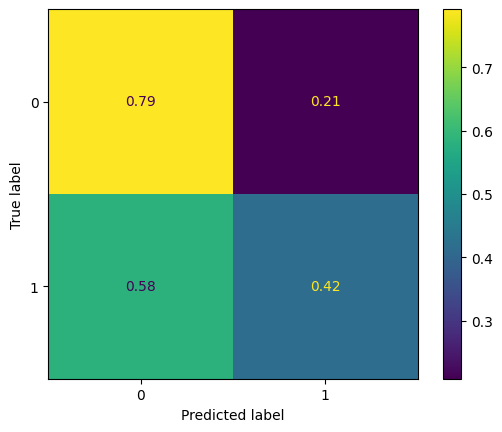

In [285]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

y_true = test_dataset['is_not_dog']
y_pred = test_dataset['gazetteer_result']

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize="true")
print(precision_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred))

0.05572755417956656 1.0 0.10557184750733138


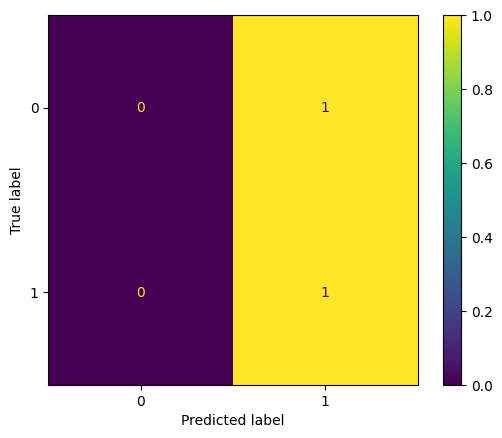

In [286]:
tudo_verdade = np.ones_like(y_true)
ConfusionMatrixDisplay.from_predictions(y_true, tudo_verdade, normalize="true")
print(precision_score(y_true, tudo_verdade), recall_score(y_true, tudo_verdade), f1_score(y_true, tudo_verdade))